# Простейшие нейронные сети с Keras

**ВНИМАНИЕ:** Чтобы работать с Keras, у вас уже должен быть установлен хотя бы один из фреймворков — Theano или Tensorflow.

## 1. О данных и бэйзлайнах

В этом задании нам доведётся построить несколько своих первых нейронных сетей для решения задачи классификации. Вам придётся так подобрать число нейронов, чтобы с одной стороны модель была не очень сложной и не переобучалась, а с другой стороны давала бы достаточно хороший прогноз. 

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
X = pd.read_csv('datasets/X_cat.csv', sep = '\t', index_col=0)
outcome = pd.read_csv('datasets/y_cat.csv', sep = '\t', index_col=0, header=-1)[1].get_values()
print(X.shape)
print(outcome.shape)
X.head()

(26729, 37)
(26729,)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

Text(0.5,0,'Outcome Type')

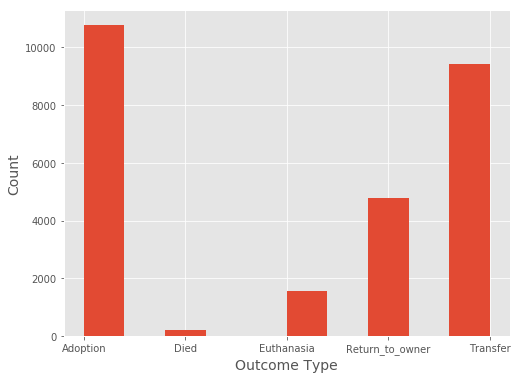

In [3]:
plt.figure(figsize=(8,6))
plt.hist(outcome)
plt.xticks(rotation=0)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Outcome Type', fontsize=14)

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [4]:
outcome[outcome == 'Died'] = 'Euthanasia'

Закодируем классы.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(outcome)
y

array([2, 1, 0, ..., 0, 3, 3])

In [6]:
len(y)

26729

In [7]:
X.shape

(26729, 37)

Построим ещё несколько красивых картинок, описывающих как класс животного зависит от его параметров. Раскрасим котов и собак в разные цвета. 

In [ ]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

plt.figure(figsize=(16, 36))
for i in range (1, X.shape[1]):
    plt.subplot(X.shape[1]//4, 4, i)
    plt.scatter(jitter(y), jitter(X.ix[:, i]), c=X["IsDog"], edgecolors="black")
    plt.xlabel('Outcome type', fontsize=14)
    plt.ylabel(str(X.columns[i]), fontsize=14)

Разобьём выборку на тренировочную и тестовую. 

In [8]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [9]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [10]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

## Логистическая регрессия

In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

0.8941734842645639

In [12]:
logreg.predict_proba(X_test)

array([[0.55047232, 0.02125922, 0.06170543, 0.36656303],
       [0.55019364, 0.03224388, 0.28689911, 0.13066337],
       [0.21835237, 0.05335936, 0.06728512, 0.66100314],
       ...,
       [0.67233488, 0.00709066, 0.22806096, 0.0925135 ],
       [0.51913448, 0.03507788, 0.00377972, 0.44200791],
       [0.71063719, 0.00756519, 0.17492977, 0.10686785]])

### Случайный лес 

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.7621819417072312

In [14]:
rf.predict_proba(X_test)

array([[0.841, 0.01 , 0.018, 0.131],
       [0.384, 0.072, 0.264, 0.28 ],
       [0.516, 0.201, 0.084, 0.199],
       ...,
       [0.246, 0.003, 0.26 , 0.491],
       [0.798, 0.028, 0.026, 0.148],
       [0.823, 0.004, 0.123, 0.05 ]])

Неплохой результат. Попробуем улучшить его с помошью нейросеток. 

## 2. Собираем свою нейросеть

In [15]:
import keras
from keras.models import Sequential   # Последовательность слоёв
import keras.layers as L              # Разные слои
import keras.optimizers as opt        # Оптимизаторы
from keras.utils.np_utils import to_categorical  # Для преобразования y в категориальный формат 

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [16]:
def get_new_model( ):
    # Задаём модель и называем её ...
    model = Sequential(name = 'Archibald')

    # Добавляем в нашу модель первый слой из 25 нейронов
    # На вход в эти 25 нейронов будут индти все наши регрессоры
    model.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))

    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('sigmoid'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))

    # В качестве оптимизации будем использовать Adam
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модельa
    model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    return model

model = get_new_model( )

Итак, только что мы собрали свою первую нейросеть с двумя скрытыми слоями.   Посмотрим сколько параметров нам предстоит оценить. 

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                950       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 104       
Total params: 1,704
Trainable params: 1,704
Non-trainable params: 0
_________________________________________________________________


Видим, что нужно оценить огромное количество параметров. На оценку каждого параметра придётся совсем маленькое количество наблюдений. 

In [18]:
X_train.shape[0]/1704

12.548708920187794

Отлично! Модель собрана. Осталось её обучить. Метод `fit` позволяет сделать это. Он принимает на вход обучаюзиую выборку `X_train, y_train`. Параметр  `batch_size` это  размер батча. Этот параметр ограничивает количество примеров, которое за раз подаётся в нашу нейронную сеть. Количиство эпох для обучения, `epochs`, это сичсло проходов модели по обучающей выборке. 

Обычно нейросетки обучаются довольно долго. В связи с этим обучать их на раздичных фолдах и оценивать качество работы модели на кросс-валидации не очень быстрое занятие, которое себе может позволить далеко не каждый. Для проверки качества обычно внутри обучения с помощью параметра `validation_split` часть выборки оставляют под валидацию, которая осуществляется после каждой эпохи. Как только качество на валидации начнёт падать, это будет означать, что модель переобучилаcь. 

Всё, что будет нам возвращать метод `.fit`, мы запишем в переменную `hist`. После обученя модели там окажется вся история ошибок на каждом шаге обучения. Отключить сообщения о том, на каком этапе обучения в данный момент находится модель, можно с параметром `verbose = 0`. Переменную $y$ для успешного обучения сетки нужно будет перевести в матрицу из дамми-переменных с помощью команды `to_categorical`. 

In [19]:
to_categorical(y)

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [25]:
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=100, verbose=1)

Train on 17106 samples, validate on 4277 samples
Epoch 1/100
17106/17106 [==============================] - 1s 47us/step - loss: 1.1337 - acc: 0.4236 - val_loss: 1.1344 - val_acc: 0.4171
Epoch 2/100
17106/17106 [==============================] - 1s 49us/step - loss: 1.1346 - acc: 0.4234 - val_loss: 1.1346 - val_acc: 0.4171
Epoch 3/100
17106/17106 [==============================] - 1s 48us/step - loss: 1.1333 - acc: 0.4244 - val_loss: 1.1312 - val_acc: 0.4171
Epoch 4/100
17106/17106 [==============================] - 1s 48us/step - loss: 1.1338 - acc: 0.4268 - val_loss: 1.1321 - val_acc: 0.4171
Epoch 5/100
17106/17106 [==============================] - 1s 46us/step - loss: 1.1336 - acc: 0.4286 - val_loss: 1.1310 - val_acc: 0.4227
Epoch 6/100
17106/17106 [==============================] - 1s 47us/step - loss: 1.1320 - acc: 0.4222 - val_loss: 1.1350 - val_acc: 0.4171
Epoch 7/100
17106/17106 [==============================] - 1s 47us/step - loss: 1.1376 - acc: 0.4197 - val_loss: 1.1368 - v

17106/17106 [==============================] - 1s 44us/step - loss: 1.0683 - acc: 0.5212 - val_loss: 1.0591 - val_acc: 0.5291
Epoch 60/100
17106/17106 [==============================] - 1s 44us/step - loss: 1.0650 - acc: 0.5257 - val_loss: 1.0858 - val_acc: 0.5184
Epoch 61/100
17106/17106 [==============================] - 1s 44us/step - loss: 1.0662 - acc: 0.5243 - val_loss: 1.0499 - val_acc: 0.5300
Epoch 62/100
17106/17106 [==============================] - 1s 45us/step - loss: 1.0636 - acc: 0.5287 - val_loss: 1.0623 - val_acc: 0.5298
Epoch 63/100
17106/17106 [==============================] - 1s 45us/step - loss: 1.0552 - acc: 0.5353 - val_loss: 1.0380 - val_acc: 0.5403
Epoch 64/100
17106/17106 [==============================] - 1s 45us/step - loss: 1.0055 - acc: 0.5747 - val_loss: 0.9988 - val_acc: 0.5915
Epoch 65/100
17106/17106 [==============================] - 1s 45us/step - loss: 0.9644 - acc: 0.6034 - val_loss: 0.9249 - val_acc: 0.6191
Epoch 66/100
17106/17106 [==============

Посмотрим на динамику ошибок нашей модели во времени. 

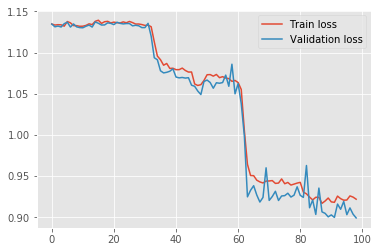

In [26]:
start = 1
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

Модель сходится довольно плохо. Функция потерь на валидации со временем начинает скакать. 

In [22]:
# Можно предсказать вероятности для тестовой выборки
model.predict_proba(X_test)

array([[0.48386082, 0.03914756, 0.01863318, 0.4583584 ],
       [0.45332178, 0.04693261, 0.13341437, 0.36633128],
       [0.48386082, 0.03914758, 0.01863327, 0.45835823],
       ...,
       [0.45332178, 0.04693261, 0.13341437, 0.36633128],
       [0.48386082, 0.03914747, 0.01863289, 0.45835882],
       [0.48386088, 0.03914754, 0.01863314, 0.45835844]], dtype=float32)

In [23]:
# А можно классы 
model.predict_classes(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# Можно найти logloss 
log_loss(y_test,model.predict_proba(X_test))

0.9240693842878602

In [ ]:
# Можно сохранить модель
model.save("weights.h5")

In [28]:
# Можно посмотреть на качество модели по всем указанным при коммпиляции метрикам. 
score = model.evaluate(X_test, to_categorical(y_test))
score 

5346/5346 [==============================] - 0s 18us/step


[0.9240693743537528, 0.6054994388327721]

Вспомним про такую замечательную штуку как нормальзация и посмотрим насколько она улучшит скорость обучения и качество модели. Заодно увеличим количество эпох. Ударим двойным кулаком по плохой сходимости. 

In [30]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

model = get_new_model( ) # Сбросим старые результаты обучения 
hist = model.fit(ss.fit_transform(X_train), to_categorical(y_train), validation_split=0.2, epochs=100, verbose=1)

Train on 17106 samples, validate on 4277 samples
Epoch 1/100
17106/17106 [==============================] - 1s 67us/step - loss: 1.1234 - acc: 0.5279 - val_loss: 0.9733 - val_acc: 0.6037
Epoch 2/100
17106/17106 [==============================] - 1s 48us/step - loss: 0.9424 - acc: 0.6160 - val_loss: 0.8958 - val_acc: 0.6296
Epoch 3/100
17106/17106 [==============================] - 1s 47us/step - loss: 0.8935 - acc: 0.6340 - val_loss: 0.8769 - val_acc: 0.6451
Epoch 4/100
17106/17106 [==============================] - 1s 47us/step - loss: 0.8840 - acc: 0.6393 - val_loss: 0.8725 - val_acc: 0.6458
Epoch 5/100
17106/17106 [==============================] - 1s 47us/step - loss: 0.8782 - acc: 0.6405 - val_loss: 0.8661 - val_acc: 0.6469
Epoch 6/100
17106/17106 [==============================] - 1s 47us/step - loss: 0.8729 - acc: 0.6427 - val_loss: 0.8611 - val_acc: 0.6430
Epoch 7/100
17106/17106 [==============================] - 1s 47us/step - loss: 0.8683 - acc: 0.6430 - val_loss: 0.8565 - v

17106/17106 [==============================] - 1s 46us/step - loss: 0.7724 - acc: 0.6771 - val_loss: 0.7997 - val_acc: 0.6671
Epoch 60/100
17106/17106 [==============================] - 1s 47us/step - loss: 0.7715 - acc: 0.6788 - val_loss: 0.8000 - val_acc: 0.6673
Epoch 61/100
17106/17106 [==============================] - 1s 48us/step - loss: 0.7709 - acc: 0.6779 - val_loss: 0.8001 - val_acc: 0.6664
Epoch 62/100
17106/17106 [==============================] - 1s 48us/step - loss: 0.7701 - acc: 0.6778 - val_loss: 0.8034 - val_acc: 0.6635
Epoch 63/100
17106/17106 [==============================] - 1s 49us/step - loss: 0.7693 - acc: 0.6799 - val_loss: 0.8011 - val_acc: 0.6650
Epoch 64/100
17106/17106 [==============================] - 1s 50us/step - loss: 0.7685 - acc: 0.6794 - val_loss: 0.8005 - val_acc: 0.6624
Epoch 65/100
17106/17106 [==============================] - 1s 49us/step - loss: 0.7683 - acc: 0.6788 - val_loss: 0.8009 - val_acc: 0.6631
Epoch 66/100
17106/17106 [==============

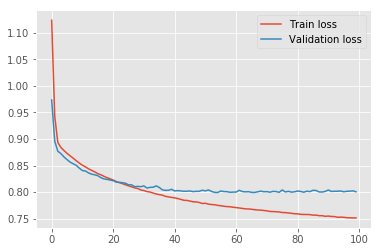

In [31]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [32]:
score = model.evaluate(ss.transform(X_test), to_categorical(y_test))
score 

5346/5346 [==============================] - 0s 20us/step


[0.8166385593817469, 0.6647961092405537]

Модель стала сходиться лучше, но мы упёрлись в новую проблему. Поначалу качество модели на валидацим возростало. Спустя несколько эпох, качество натрэйне полжило расти, а на валидации стало падоть. Как вы помните, всё это является признаками переобучения. Попробуем дать переобучению бой.  

## 3. Бои с переобучением

Существует несколько способов по регуляризации нейронных сетей. 

* EarlyStopping
* Dropout
* $l_1$ и $l_2$ регуляризация 


Попробуем всего по немногу. 

### 3.1 Early stopping

Одни сети сходятся за 5 эпох, другие не сходятся и за тысячу. Тренировать сетку в течение 1000 эпох, если она сходится за 5 - это не очень хорошая идея, так как качество на валидации начнает падать и модель переобучается. Давайте попробуем останавливать обучение модели, как только оценка качества модели на валидации падает в течение нескольких эпох. Например, пяти. 

In [ ]:
# Подгружаем раннюю остановку
from keras.callbacks import EarlyStopping

# Прикажем модели останавливать обучение, когда качество на валидации не будет улучшаться в течение двух эпох
early_stopping_monitor = EarlyStopping(patience = 5)

model = get_new_model( ) # Сбросим старые веса 
hist = model.fit(ss.fit_transform(X_train), to_categorical(y_train), validation_split=0.2, epochs=100, 
                  verbose=1, callbacks = [early_stopping_monitor])

In [ ]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [ ]:
score = model.evaluate(ss.transform(X_test), to_categorical(y_test))
score 

### 3.2  Dropout 

Попробуем новые приколы, для которых нам придётся изменять архитектуру нашей модели. Добавим в модель дропаут. 

In [33]:
from keras.layers import Dropout

model_dropout = Sequential( )

# Первый слой 
model_dropout.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))
model_dropout.add(Dropout(0.5)) # слой дропаута
model_dropout.add(L.Activation('sigmoid'))

# Второй слой 
model_dropout.add(L.Dense(25, kernel_initializer='random_normal'))
model_dropout.add(Dropout(0.5))
model_dropout.add(L.Activation('sigmoid'))


# Выходной слой 
model_dropout.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))

# Собираем модель 
model_dropout.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=opt.Adam(lr=1e-3))

In [34]:
# Прикажем модели останавливать обучение, когда качество на валидации не будет улучшаться в течение двух эпох
hist = model_dropout.fit(ss.fit_transform(X_train), to_categorical(y_train), 
                         validation_split=0.2, epochs=100, verbose=1)

Train on 17106 samples, validate on 4277 samples
Epoch 1/100
17106/17106 [==============================] - 1s 77us/step - loss: 1.2007 - acc: 0.4757 - val_loss: 1.0374 - val_acc: 0.6128
Epoch 2/100
17106/17106 [==============================] - 1s 54us/step - loss: 1.0391 - acc: 0.6081 - val_loss: 0.9694 - val_acc: 0.6156
Epoch 3/100
17106/17106 [==============================] - 1s 57us/step - loss: 0.9918 - acc: 0.6079 - val_loss: 0.9345 - val_acc: 0.6189
Epoch 4/100
17106/17106 [==============================] - 1s 54us/step - loss: 0.9660 - acc: 0.6093 - val_loss: 0.9200 - val_acc: 0.6364
Epoch 5/100
17106/17106 [==============================] - 1s 56us/step - loss: 0.9444 - acc: 0.6172 - val_loss: 0.9045 - val_acc: 0.6385
Epoch 6/100
17106/17106 [==============================] - 1s 55us/step - loss: 0.9359 - acc: 0.6216 - val_loss: 0.9209 - val_acc: 0.6434
Epoch 7/100
17106/17106 [==============================] - 1s 56us/step - loss: 0.9288 - acc: 0.6252 - val_loss: 0.9140 - v

17106/17106 [==============================] - 1s 50us/step - loss: 0.9003 - acc: 0.6319 - val_loss: 0.9335 - val_acc: 0.6409
Epoch 60/100
17106/17106 [==============================] - 1s 51us/step - loss: 0.8986 - acc: 0.6289 - val_loss: 0.9266 - val_acc: 0.6402
Epoch 61/100
17106/17106 [==============================] - 1s 51us/step - loss: 0.8959 - acc: 0.6321 - val_loss: 0.9325 - val_acc: 0.6383
Epoch 62/100
17106/17106 [==============================] - 1s 52us/step - loss: 0.8971 - acc: 0.6318 - val_loss: 0.9295 - val_acc: 0.6320
Epoch 63/100
17106/17106 [==============================] - 1s 51us/step - loss: 0.8923 - acc: 0.6283 - val_loss: 0.9427 - val_acc: 0.6367
Epoch 64/100
17106/17106 [==============================] - 1s 51us/step - loss: 0.8932 - acc: 0.6367 - val_loss: 0.9328 - val_acc: 0.6409
Epoch 65/100
17106/17106 [==============================] - 1s 51us/step - loss: 0.8950 - acc: 0.6318 - val_loss: 0.9347 - val_acc: 0.6376
Epoch 66/100
17106/17106 [==============

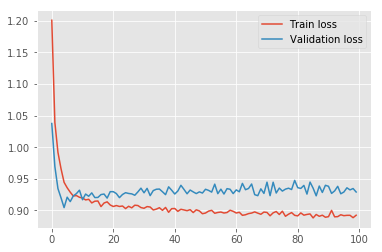

In [35]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [36]:
score = model_dropout.evaluate(ss.transform(X_test), to_categorical(y_test))
score 

5346/5346 [==============================] - 0s 21us/step


[0.9669579865443675, 0.6333707444818556]

In [37]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


### Различные воспитательные трюки 

1. Начните с маленькой сети. Не забывайте прикидывать сколько наблдюдений $n$ тратится на оценку каждого из $k$ параметров. Если величина $\frac{n}{k}$ очень маленькая, то не может идти речи об адекватных оценках параметров!  
2. Всегда оставляйте часть выборки под валидацию на каждой эпохе.
3. Усложняйте модель, пока качество на валидации не начнёт падать.
4. Не забывайте проскалировать ваши наблюдения для лучшей сходимости. 
5. Можно попробовать ещё целую серию различных **трюков**: 


* __Архитектура нейросети__
    * Больше/меньше нейронов
    * Больше/меньше слоёв 
    * Другие функции активации (tanh, relu, leaky relu, etc) 
    * Регуляризация (dropout, l1,l2) 


* __Более качественная оптимизация__  
    * Можно попробовать выбрать другой метод оптимизации 
    * Можно попробовать менять скорость обучения, моментум и др.


* __Попробовать собрать больше данных__ 
* __Для случая картинок объёмы данных можно увеличить искусственно с помощью подхода, который называется Data augmemntation, но об этом позже__

И это далеко не полный список. Обратите внимание, что делать grid_search для больших сеток это довольно времязатратное занятие... 